In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

def create_cnn(input_shape):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1))
    return model

# Example usage
input_shape = (224, 224, 3)  # Adjust according to your image size
model = create_cnn(input_shape)

# Print model summary
model.summary()

from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mean_absolute_error'])


C:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      11,075,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,169,089 (42.61 MB)

 Trainable params: 11,169,089 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [2]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Load image paths
def load_image_paths(file_path):
    with open(file_path, 'r') as f:
        return [line.strip() for line in f]

# Load MOS values
def load_mos_values(file_path):
    return np.loadtxt(file_path, delimiter=',')

# Load splits from files
train_images = load_image_paths('train_images_new.txt')
test_images = load_image_paths('test_images_new.txt')

train_mos = load_mos_values('train_mos_new.txt')
test_mos = load_mos_values('test_mos.txt')

# Split train data into train and validation sets
train_images, val_images, train_mos, val_mos = train_test_split(train_images, train_mos, test_size=0.2, random_state=42)

# Create TensorFlow dataset
def create_dataset(image_paths, mos_values, batch_size=32, size=(224, 224)):
    def load_and_preprocess_image(path, label):
        img = tf.io.read_file(path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, size)
        img = img / 255.0
        return img, label

    dataset = tf.data.Dataset.from_tensor_slices((image_paths, mos_values))
    dataset = dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

batch_size = 32

train_dataset = create_dataset(train_images, train_mos, batch_size)
val_dataset = create_dataset(val_images, val_mos, batch_size)
test_dataset = create_dataset(test_images, test_mos, batch_size)


In [5]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import mean_squared_error, r2_score

# Define data augmentation
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom

# Define data augmentation
data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal_and_vertical"),
    RandomRotation(0.2),
    RandomZoom(0.2)
])



# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss')


# Train the model
history = model.fit(
    train_dataset.map(lambda x, y: (data_augmentation(x, training=True), y)),
    epochs=50,
    validation_data=val_dataset,
    callbacks=[early_stopping, model_checkpoint]
)

# Evaluate on the test set
test_loss, test_mae = model.evaluate(test_dataset)
print("Test MAE:", test_mae)

# Predict and calculate additional metrics
y_test_pred = model.predict(test_dataset)
test_rmse = np.sqrt(mean_squared_error(test_mos, y_test_pred))
test_r2 = r2_score(test_mos, y_test_pred)
print("Test RMSE:", test_rmse)
print("Test R²:", test_r2)


Epoch 1/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 81s 450ms/step - loss: 665.7075 - mean_absolute_error: 18.1755 - val_loss: 182.0707 - val_mean_absolute_error: 5.5760
Epoch 2/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 79s 448ms/step - loss: 184.8542 - mean_absolute_error: 9.5386 - val_loss: 176.0422 - val_mean_absolute_error: 5.0908
Epoch 3/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 80s 455ms/step - loss: 173.2635 - mean_absolute_error: 8.9188 - val_loss: 172.2426 - val_mean_absolute_error: 4.8952
Epoch 4/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 79s 447ms/step - loss: 172.0132 - mean_absolute_error: 9.0883 - val_loss: 205.8143 - val_mean_absolute_error: 6.9305
Epoch 5/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 78s 444ms/step - loss: 185.7682 - mean_absolute_error: 9.4825 - val_loss: 213.3833 - val_mean_absolute_error: 7.6015
Epoch 6/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 81s 461ms/step - loss: 170.3247 - mean_absolute_error: 8.8270 - val_loss: 191.7928 - val_mean_absolute_error: 6.2631
Epoch 7/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 78s 443ms/step - 

In [6]:
import numpy as np
from scipy.stats import spearmanr, kendalltau, pearsonr
import tensorflow as tf

# Ensure the model and datasets are loaded
# Assuming train_dataset, val_dataset, test_dataset are already defined
# and the model is already trained and loaded

# Load best model
model = tf.keras.models.load_model('best_model.keras')

# Helper function to get predictions and ground truth values from a dataset
def get_predictions_and_ground_truth(dataset):
    y_true = []
    y_pred = []
    
    for images, mos in dataset:
        y_true.extend(mos.numpy())
        y_pred.extend(model.predict(images).flatten())
    
    return np.array(y_true), np.array(y_pred)

# Get predictions and ground truth for the validation set
y_true_val, y_pred_val = get_predictions_and_ground_truth(val_dataset)

# Get predictions and ground truth for the test set
y_true_test, y_pred_test = get_predictions_and_ground_truth(test_dataset)

# Calculate SRCC, KRCC, and PLCC for validation set
srcc_val, _ = spearmanr(y_true_val, y_pred_val)
krcc_val, _ = kendalltau(y_true_val, y_pred_val)
plcc_val, _ = pearsonr(y_true_val, y_pred_val)

# Calculate SRCC, KRCC, and PLCC for test set
srcc_test, _ = spearmanr(y_true_test, y_pred_test)
krcc_test, _ = kendalltau(y_true_test, y_pred_test)
plcc_test, _ = pearsonr(y_true_test, y_pred_test)

print("Validation Set:")
print(f"SRCC: {srcc_val}")
print(f"KRCC: {krcc_val}")
print(f"PLCC: {plcc_val}")

print("\nTest Set:")
print(f"SRCC: {srcc_test}")
print(f"KRCC: {krcc_test}")
print(f"PLCC: {plcc_test}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s

In [3]:
!pip install keras-tuner



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
import tensorflow as tf
import numpy as np
import keras_tuner as kt
from sklearn.model_selection import train_test_split

# Define the functions to load image paths and MOS values
def load_image_paths(file_path):
    with open(file_path, 'r') as f:
        return [line.strip() for line in f]

def load_mos_values(file_path):
    return np.loadtxt(file_path, delimiter=',')

# Define the function to create TensorFlow dataset
def create_dataset(image_paths, mos_values, batch_size=32, size=(224, 224)):
    def load_and_preprocess_image(path, label):
        img = tf.io.read_file(path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, size)
        img = img / 255.0  # Normalize to [0, 1] range
        return img, label

    dataset = tf.data.Dataset.from_tensor_slices((image_paths, mos_values))
    dataset = dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset


In [5]:
# Define paths for the data files
train_images_path = 'train_images_new.txt'
test_images_path = 'test_images_new.txt'
train_mos_path = 'train_mos_new.txt'
test_mos_path = 'test_mos.txt'

# Load the data
train_images = load_image_paths(train_images_path)
test_images = load_image_paths(test_images_path)
train_mos = load_mos_values(train_mos_path)
test_mos = load_mos_values(test_mos_path)

# Split train data into train and validation sets
train_images, val_images, train_mos, val_mos = train_test_split(train_images, train_mos, test_size=0.2, random_state=42)

# Create the datasets
batch_size = 32
train_dataset = create_dataset(train_images, train_mos, batch_size)
val_dataset = create_dataset(val_images, val_mos, batch_size)
test_dataset = create_dataset(test_images, test_mos, batch_size)


In [6]:
# Define the model building function
def build_model(hp):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=(224, 224, 3)),  # Add Input layer
        tf.keras.layers.Conv2D(
            filters=hp.Int('conv_1_filters', min_value=16, max_value=32, step=16),
            kernel_size=hp.Choice('conv_1_kernel', values=[3]),
            activation='relu'
        ),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(
            units=hp.Int('dense_units', min_value=32, max_value=64, step=32),
            activation='relu'
        ),
        tf.keras.layers.Dense(1, activation='linear')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Float('learning_rate', min_value=1e-5, max_value=1e-3, sampling='log')),
        loss='mean_squared_error',
        metrics=['mean_absolute_error']
    )

    return model


# Initialize the tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=5,  # Limited trials
    executions_per_trial=1,
    directory='my_dir',
    project_name='hyperparameter_tuning'
)

# Define early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)


Reloading Tuner from my_dir\hyperparameter_tuning\tuner0.json


In [13]:
# Perform hyperparameter search
tuner.search(
    train_dataset,
    epochs=50,
    validation_data=val_dataset,
    callbacks=[early_stopping],
    verbose=1
)

# Display the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best hyperparameters: {best_hps.values}")


Trial 5 Complete [00h 28m 31s]
val_loss: 159.8617401123047

Best val_loss So Far: 159.8617401123047
Total elapsed time: 01h 09m 47s
Best hyperparameters: {'conv_1_filters': 32, 'conv_1_kernel': 3, 'dense_units': 32, 'learning_rate': 1.1553957581855082e-05}


In [7]:
import keras_tuner as kt

# Reload the tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=3,
    executions_per_trial=1,
    directory='my_dir',
    project_name='hyperparameter_tuning'
)

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best hyperparameters: {best_hps.values}")


Reloading Tuner from my_dir\hyperparameter_tuning\tuner0.json
Best hyperparameters: {'conv_1_filters': 32, 'conv_1_kernel': 3, 'dense_units': 32, 'learning_rate': 1.1553957581855082e-05}


In [9]:
def build_best_model(hp):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=(224, 224, 3)),  # Add an Input layer
        tf.keras.layers.Conv2D(
            filters=best_hps.get('conv_1_filters'),
            kernel_size=best_hps.get('conv_1_kernel'),
            activation='relu'
        ),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(
            units=best_hps.get('dense_units'),
            activation='relu'
        ),
        tf.keras.layers.Dense(1, activation='linear')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=best_hps.get('learning_rate')),
        loss='mean_squared_error',
        metrics=['mean_absolute_error']
    )

    return model

# Build the model
best_model = build_best_model(best_hps)


In [10]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

history = best_model.fit(
    train_dataset,
    epochs=50,  # Adjust based on your requirements
    validation_data=val_dataset,
    callbacks=[early_stopping]
)


Epoch 1/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 36s 197ms/step - loss: 1235.0687 - mean_absolute_error: 26.1667 - val_loss: 202.1551 - val_mean_absolute_error: 7.0309
Epoch 2/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 34s 195ms/step - loss: 109.5686 - mean_absolute_error: 6.6556 - val_loss: 191.9915 - val_mean_absolute_error: 6.4416
Epoch 3/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 35s 196ms/step - loss: 98.0369 - mean_absolute_error: 6.0195 - val_loss: 179.4177 - val_mean_absolute_error: 5.5988
Epoch 4/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 35s 200ms/step - loss: 84.7471 - mean_absolute_error: 5.1319 - val_loss: 169.5348 - val_mean_absolute_error: 4.7805
Epoch 5/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 36s 206ms/step - loss: 75.0397 - mean_absolute_error: 4.3473 - val_loss: 165.1851 - val_mean_absolute_error: 4.3109
Epoch 6/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 35s 200ms/step - loss: 70.9685 - mean_absolute_error: 3.9648 - val_loss: 163.9144 - val_mean_absolute_error: 4.1737
Epoch 7/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 36s 204ms/step - los

In [11]:
import tensorflow as tf

# Load the best model
best_model = tf.keras.models.load_model('best_model.keras')


In [12]:
# Evaluate the model on the test set
test_loss, test_mae = best_model.evaluate(test_dataset)
print(f"Test Loss: {test_loss}, Test MAE: {test_mae}")


47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 90ms/step - loss: 36.2847 - mean_absolute_error: 4.3508
Test Loss: 41.37228775024414, Test MAE: 4.498768329620361


In [14]:
import tensorflow as tf
import numpy as np

# Define the functions to load image paths and MOS values
def load_image_paths(file_path):
    with open(file_path, 'r') as f:
        return [line.strip() for line in f]

def load_mos_values(file_path):
    return np.loadtxt(file_path, delimiter=',')

# Define the function to create TensorFlow dataset
def create_dataset(image_paths, mos_values, batch_size=16, size=(224, 224)):
    def load_and_preprocess_image(path, label):
        img = tf.io.read_file(path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, size)
        img = img / 255.0  # Normalize to [0, 1] range
        return img, label

    dataset = tf.data.Dataset.from_tensor_slices((image_paths, mos_values))
    dataset = dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

# Define paths for the test data files
test_images_path = 'test_images_new.txt'
test_mos_path = 'test_mos.txt'

# Load the test data
test_images = load_image_paths(test_images_path)
test_mos = load_mos_values(test_mos_path)

# Create the test dataset
batch_size = 32  # Use the same batch size as used in training
test_dataset = create_dataset(test_images, test_mos, batch_size)


In [15]:
import tensorflow as tf
import numpy as np
from scipy.stats import spearmanr, kendalltau, pearsonr
from sklearn.metrics import mean_squared_error

# Load the best model
best_model = tf.keras.models.load_model('best_model.keras')

# Evaluate the model on the test set
test_loss, test_mae = best_model.evaluate(test_dataset)
print(f"Test Loss: {test_loss}, Test MAE: {test_mae}")

# Make predictions on the test set
predictions = best_model.predict(test_dataset)

# Assuming test_mos contains the true MOS values
predicted_mos = predictions.flatten()

# Calculate and print SRCC, KRCC, PLCC, and RMSE
srcc, _ = spearmanr(test_mos, predicted_mos)
print(f"Spearman Rank Correlation Coefficient (SRCC): {srcc}")

krcc, _ = kendalltau(test_mos, predicted_mos)
print(f"Kendall Rank Correlation Coefficient (KRCC): {krcc}")

plcc, _ = pearsonr(test_mos, predicted_mos)
print(f"Pearson Linear Correlation Coefficient (PLCC): {plcc}")

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test_mos, predicted_mos))
print(f"Root Mean Squared Error (RMSE): {rmse}")


47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step - loss: 36.2847 - mean_absolute_error: 4.3508
Test Loss: 41.37228775024414, Test MAE: 4.498768329620361
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 78ms/step
Spearman Rank Correlation Coefficient (SRCC): 0.8807233895980391
Kendall Rank Correlation Coefficient (KRCC): 0.7090308405213964
Pearson Linear Correlation Coefficient (PLCC): 0.8701323284582019
Root Mean Squared Error (RMSE): 6.432128615890056


In [16]:
!pip install ipywidgets



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Model loaded successfully.
Loaded 1504 image paths.
Loaded MOS values for 1504 images.
Selected 10 images for evaluation.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


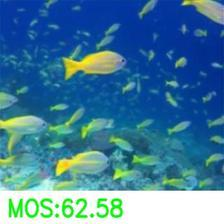

Image: output\resized_im_u1037_.jpg
True MOS: 62.58
Predicted MOS: 62.31


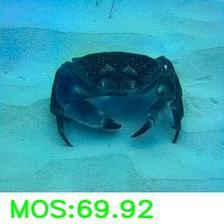

Image: output\resized_resized_269297_00020848.jpg
True MOS: 69.92
Predicted MOS: 73.38


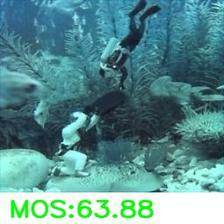

Image: output\resized_270034_scuba_aquarium_89.jpg
True MOS: 63.88
Predicted MOS: 66.84


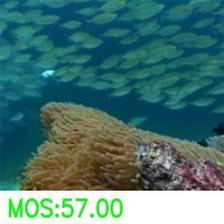

Image: output\resized_nm_170up.jpg
True MOS: 57.0
Predicted MOS: 54.78


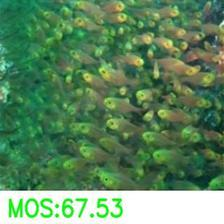

Image: output\resized_nm_1297up.jpg
True MOS: 67.53
Predicted MOS: 67.35


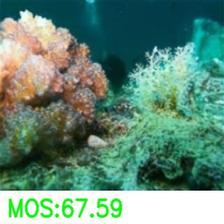

Image: output\resized_nm_1325up.jpg
True MOS: 67.59
Predicted MOS: 67.93


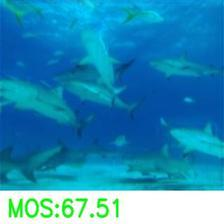

Image: output\resized_im_u512_.jpg
True MOS: 67.51
Predicted MOS: 63.53


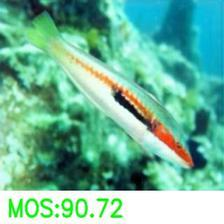

Image: output\resized_im_f130_.jpg
True MOS: 90.72
Predicted MOS: 84.44


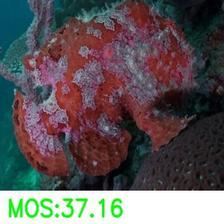

Image: output\resized_gmn_5299up.jpg
True MOS: 37.16
Predicted MOS: 41.05


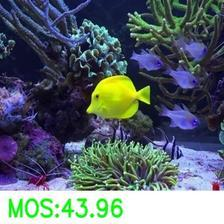

Image: output\resized_gmn_7159up.jpg
True MOS: 43.96
Predicted MOS: 43.46


In [30]:
#finalize this .This is this the final output
import tensorflow as tf
import numpy as np
import random
from IPython.display import display, Image, HTML
import matplotlib.pyplot as plt
import scipy.stats as stats
import os

# Load the saved model
try:
    model = tf.keras.models.load_model('best_model.keras')
    print("Model loaded successfully.")
except Exception as e:
    print(f"Error loading model: {e}")

# Define paths for the image dataset and MOS values
image_paths_file = 'test_images_new.txt'
mos_values_file = 'test_mos.txt'

# Load the image paths and MOS values
def load_image_paths(file_path):
    if not os.path.isfile(file_path):
        raise FileNotFoundError(f"Image paths file not found: {file_path}")
    with open(file_path, 'r') as f:
        paths = [line.strip() for line in f]
    print(f"Loaded {len(paths)} image paths.")
    return paths

def load_mos_values(file_path):
    if not os.path.isfile(file_path):
        raise FileNotFoundError(f"MOS values file not found: {file_path}")
    values = np.loadtxt(file_path, delimiter=',')
    print(f"Loaded MOS values for {len(values)} images.")
    return values

try:
    image_paths = load_image_paths(image_paths_file)
    mos_values = load_mos_values(mos_values_file)
except Exception as e:
    print(f"Error loading data: {e}")

# Define a function to preprocess images
def preprocess_image(path, size=(224, 224)):
    if not os.path.isfile(path):
        raise FileNotFoundError(f"Image file not found: {path}")
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, size)
    img = img / 255.0  # Normalize to [0, 1] range
    return img

# Define a function to get predictions and metrics
def predict_and_evaluate(image_paths, true_mos_values):
    predictions = []
    true_values = []

    for i in range(len(image_paths)):
        image_path = image_paths[i]
        true_mos = true_mos_values[i]

        # Preprocess the image
        image = preprocess_image(image_path)
        image = np.expand_dims(image, axis=0)  # Add batch dimension

        # Predict the MOS value
        predicted_mos = model.predict(image)[0][0]

        predictions.append(predicted_mos)
        true_values.append(true_mos)

    # Calculate metrics
    srcc, _ = stats.spearmanr(true_values, predictions)
    krcc, _ = stats.kendalltau(true_values, predictions)
    plcc = np.corrcoef(true_values, predictions)[0, 1]

    return predictions, srcc, krcc, plcc

# Select multiple random images
num_samples = 10  # Number of images to sample
indices = random.sample(range(len(image_paths)), num_samples)
sample_image_paths = [image_paths[i] for i in indices]
sample_mos_values = [mos_values[i] for i in indices]

print(f"Selected {num_samples} images for evaluation.")

# Predict and evaluate
predictions, srcc, krcc, plcc = predict_and_evaluate(sample_image_paths, sample_mos_values)

# Display results
for i in range(num_samples):
    img = Image(filename=sample_image_paths[i])
    display(img)
    print(f"Image: {sample_image_paths[i]}")
    print(f"True MOS: {sample_mos_values[i]}")
    print(f"Predicted MOS: {predictions[i]:.2f}")

results = f"""
<h3>Evaluation Results</h3>
<p><b>Spearman Rank Correlation Coefficient (SRCC):</b> {srcc:.4f}</p>
<p><b>Kendall Rank Correlation Coefficient (KRCC):</b> {krcc:.4f}</p>
<p><b>Pearson Linear Correlation Coefficient (PLCC):</b> {plcc:.4f}</p>
"""
display(HTML(results))


Model loaded successfully.
Loaded 1504 image paths.
Loaded MOS values for 1504 images.
Selected 10 images for evaluation.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


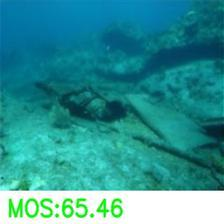

Image: output\resized_im_f79_.jpg
True MOS: 65.46
Predicted MOS: 67.16
RMSE for this image: 1.70


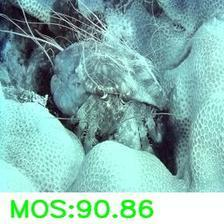

Image: output\resized_resized_265014_00027293.jpg
True MOS: 90.86
Predicted MOS: 84.26
RMSE for this image: 6.60


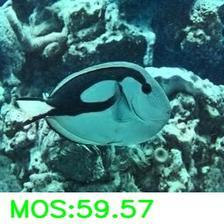

Image: output\resized_268638_00019870.jpg
True MOS: 59.57
Predicted MOS: 54.37
RMSE for this image: 5.20


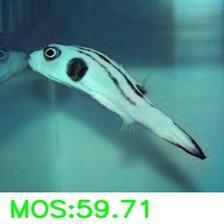

Image: output\resized_resized_265218_00005635.jpg
True MOS: 59.71
Predicted MOS: 71.99
RMSE for this image: 12.28


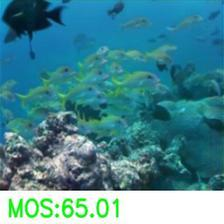

Image: output\resized_im_u478_.jpg
True MOS: 65.01
Predicted MOS: 61.28
RMSE for this image: 3.73


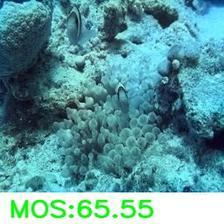

Image: output\resized_resized_267785_00037462.jpg
True MOS: 65.55
Predicted MOS: 65.98
RMSE for this image: 0.43


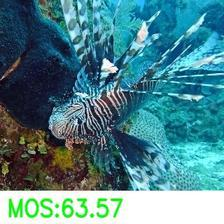

Image: output\resized_gmn_7916up.jpg
True MOS: 63.57
Predicted MOS: 54.45
RMSE for this image: 9.12


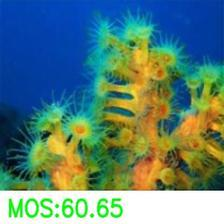

Image: output\resized_im_f692_.jpg
True MOS: 60.65
Predicted MOS: 63.69
RMSE for this image: 3.04


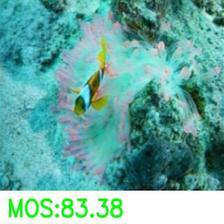

Image: output\resized_im_f2474_.jpg
True MOS: 83.38
Predicted MOS: 80.35
RMSE for this image: 3.03


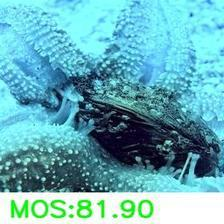

Image: output\resized_resized_269882_00028175.jpg
True MOS: 81.9
Predicted MOS: 76.07
RMSE for this image: 5.83


In [37]:
#it contains RMSE for every image(optional)
import tensorflow as tf
import numpy as np
import random
from IPython.display import display, Image, HTML
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import scipy.stats as stats
import os

# Load the saved model
try:
    model = tf.keras.models.load_model('best_model.keras')
    print("Model loaded successfully.")
except Exception as e:
    print(f"Error loading model: {e}")

# Define paths for the image dataset and MOS values
image_paths_file = 'test_images_new.txt'
mos_values_file = 'test_mos.txt'

# Load the image paths and MOS values
def load_image_paths(file_path):
    if not os.path.isfile(file_path):
        raise FileNotFoundError(f"Image paths file not found: {file_path}")
    with open(file_path, 'r') as f:
        paths = [line.strip() for line in f]
    print(f"Loaded {len(paths)} image paths.")
    return paths

def load_mos_values(file_path):
    if not os.path.isfile(file_path):
        raise FileNotFoundError(f"MOS values file not found: {file_path}")
    values = np.loadtxt(file_path, delimiter=',')
    print(f"Loaded MOS values for {len(values)} images.")
    return values

try:
    image_paths = load_image_paths(image_paths_file)
    mos_values = load_mos_values(mos_values_file)
except Exception as e:
    print(f"Error loading data: {e}")

# Define a function to preprocess images
def preprocess_image(path, size=(224, 224)):
    if not os.path.isfile(path):
        raise FileNotFoundError(f"Image file not found: {path}")
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, size)
    img = img / 255.0  # Normalize to [0, 1] range
    return img

# Define a function to get predictions and metrics
def predict_and_evaluate(image_paths, true_mos_values):
    predictions = []
    true_values = []
    rmses = []

    for i in range(len(image_paths)):
        image_path = image_paths[i]
        true_mos = true_mos_values[i]

        # Preprocess the image
        image = preprocess_image(image_path)
        image = np.expand_dims(image, axis=0)  # Add batch dimension

        # Predict the MOS value
        predicted_mos = model.predict(image)[0][0]

        # Calculate RMSE for this image
        rmse = np.sqrt(mean_squared_error([true_mos], [predicted_mos]))

        predictions.append(predicted_mos)
        true_values.append(true_mos)
        rmses.append(rmse)

    # Calculate overall metrics
    srcc, _ = stats.spearmanr(true_values, predictions)
    krcc, _ = stats.kendalltau(true_values, predictions)
    plcc = np.corrcoef(true_values, predictions)[0, 1]

    return predictions, srcc, krcc, plcc, rmses

# Select multiple random images
num_samples = 10  # Number of images to sample
indices = random.sample(range(len(image_paths)), num_samples)
sample_image_paths = [image_paths[i] for i in indices]
sample_mos_values = [mos_values[i] for i in indices]

print(f"Selected {num_samples} images for evaluation.")

# Predict and evaluate
predictions, srcc, krcc, plcc, rmses = predict_and_evaluate(sample_image_paths, sample_mos_values)

# Display results
for i in range(num_samples):
    img = Image(filename=sample_image_paths[i])
    display(img)
    print(f"Image: {sample_image_paths[i]}")
    print(f"True MOS: {sample_mos_values[i]}")
    print(f"Predicted MOS: {predictions[i]:.2f}")
    print(f"RMSE for this image: {rmses[i]:.2f}")

results = f"""
<h3>Evaluation Results</h3>
<p><b>Spearman Rank Correlation Coefficient (SRCC):</b> {srcc:.4f}</p>
<p><b>Kendall Rank Correlation Coefficient (KRCC):</b> {krcc:.4f}</p>
<p><b>Pearson Linear Correlation Coefficient (PLCC):</b> {plcc:.4f}</p>
"""
display(HTML(results))


Model loaded successfully.
Loaded 1504 image paths.
Loaded MOS values for 1504 images.
Selected image for evaluation: output\resized_nm_2402up.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


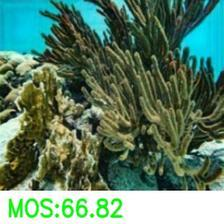

Image: output\resized_nm_2402up.jpg
True MOS: 66.82
Predicted MOS: 60.28
Absolute Error: 6.54


In [35]:
import tensorflow as tf
import numpy as np
import random
from IPython.display import display, Image, HTML
import scipy.stats as stats
import os

# Load the saved model
try:
    model = tf.keras.models.load_model('best_model.keras')
    print("Model loaded successfully.")
except Exception as e:
    print(f"Error loading model: {e}")

# Define paths for the image dataset and MOS values
image_paths_file = 'test_images_new.txt'
mos_values_file = 'test_mos.txt'

# Load the image paths and MOS values
def load_image_paths(file_path):
    if not os.path.isfile(file_path):
        raise FileNotFoundError(f"Image paths file not found: {file_path}")
    with open(file_path, 'r') as f:
        paths = [line.strip() for line in f]
    print(f"Loaded {len(paths)} image paths.")
    return paths

def load_mos_values(file_path):
    if not os.path.isfile(file_path):
        raise FileNotFoundError(f"MOS values file not found: {file_path}")
    values = np.loadtxt(file_path, delimiter=',')
    print(f"Loaded MOS values for {len(values)} images.")
    return values

try:
    image_paths = load_image_paths(image_paths_file)
    mos_values = load_mos_values(mos_values_file)
except Exception as e:
    print(f"Error loading data: {e}")

# Define a function to preprocess images
def preprocess_image(path, size=(224, 224)):
    if not os.path.isfile(path):
        raise FileNotFoundError(f"Image file not found: {path}")
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, size)
    img = img / 255.0  # Normalize to [0, 1] range
    return img

# Define a function to get predictions and simulated metrics
def predict_and_evaluate(image_path, true_mos_value):
    # Preprocess the image
    image = preprocess_image(image_path)
    image = np.expand_dims(image, axis=0)  # Add batch dimension

    # Predict the MOS value
    predicted_mos = model.predict(image)[0][0]

    # Create a "tiny dataset" with the single true and predicted MOS values
    true_values = [true_mos_value]
    predicted_values = [predicted_mos]

    # Calculate simulated metrics
    srcc, _ = stats.spearmanr(true_values, predicted_values) if len(true_values) > 1 else (np.nan, np.nan)
    krcc, _ = stats.kendalltau(true_values, predicted_values) if len(true_values) > 1 else (np.nan, np.nan)
    plcc = np.corrcoef(true_values, predicted_values)[0, 1] if len(true_values) > 1 else np.nan

    # Calculate absolute error
    abs_error = abs(true_mos_value - predicted_mos)

    return predicted_mos, abs_error, srcc, krcc, plcc

# Select a single random image
index = random.randint(0, len(image_paths) - 1)
image_path = image_paths[index]
true_mos_value = mos_values[index]

print(f"Selected image for evaluation: {image_path}")

# Predict and evaluate
predicted_mos, abs_error, srcc, krcc, plcc = predict_and_evaluate(image_path, true_mos_value)

# Display results
img = Image(filename=image_path)
display(img)
print(f"Image: {image_path}")
print(f"True MOS: {true_mos_value}")
print(f"Predicted MOS: {predicted_mos:.2f}")
print(f"Absolute Error: {abs_error:.2f}")

results = f"""
<h3>Evaluation Results</h3>
<p><b>True MOS:</b> {true_mos_value}</p>
<p><b>Predicted MOS:</b> {predicted_mos:.2f}</p>
<p><b>Absolute Error:</b> {abs_error:.2f}</p>
<p><b>Spearman Rank Correlation Coefficient (SRCC):</b> {srcc:.4f}</p>
<p><b>Kendall Rank Correlation Coefficient (KRCC):</b> {krcc:.4f}</p>
<p><b>Pearson Linear Correlation Coefficient (PLCC):</b> {plcc:.4f}</p>
"""
display(HTML(results))


Model loaded successfully.
Loaded 1504 image paths.
Loaded MOS values for 1504 images.
Selected 10 images for evaluation.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


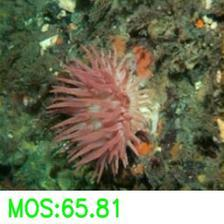

Image: output\resized_im_f443_.jpg
True MOS: 65.81
Predicted MOS: 60.51
RMSE for this image: 5.30


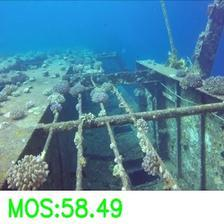

Image: output\resized_gmn_6093up.jpg
True MOS: 58.49
Predicted MOS: 68.45
RMSE for this image: 9.96


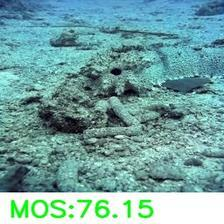

Image: output\resized_270940_00020152.jpg
True MOS: 76.15
Predicted MOS: 72.97
RMSE for this image: 3.18


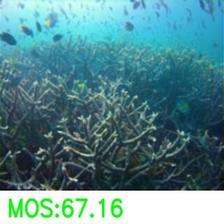

Image: output\resized_im_u1670_.jpg
True MOS: 67.16
Predicted MOS: 58.34
RMSE for this image: 8.82


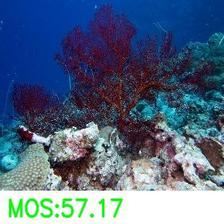

Image: output\resized_gmn_5515up.jpg
True MOS: 57.17
Predicted MOS: 53.19
RMSE for this image: 3.98


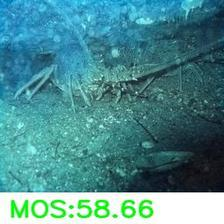

Image: output\resized_270186_00031990.jpg
True MOS: 58.66
Predicted MOS: 61.48
RMSE for this image: 2.82


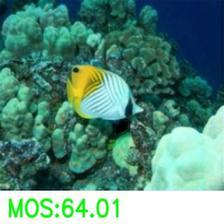

Image: output\resized_im_f1470_.jpg
True MOS: 64.01
Predicted MOS: 63.61
RMSE for this image: 0.40


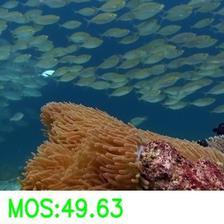

Image: output\resized_gmn_6675up.jpg
True MOS: 49.63
Predicted MOS: 52.30
RMSE for this image: 2.67


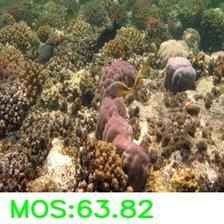

Image: output\resized_272715_00010322.jpg
True MOS: 63.82
Predicted MOS: 62.14
RMSE for this image: 1.68


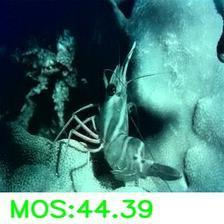

Image: output\resized_resized_268461_00027612.jpg
True MOS: 44.39
Predicted MOS: 54.32
RMSE for this image: 9.93


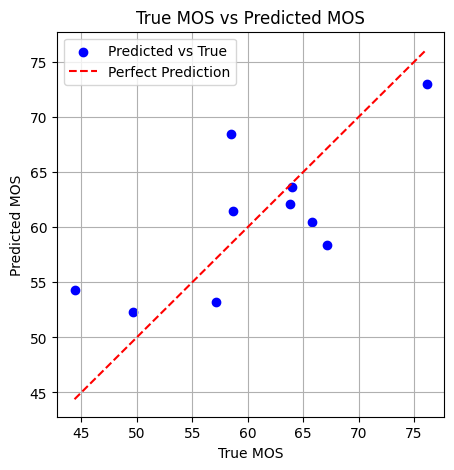

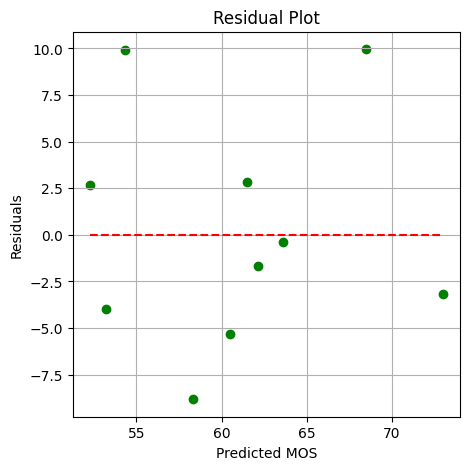

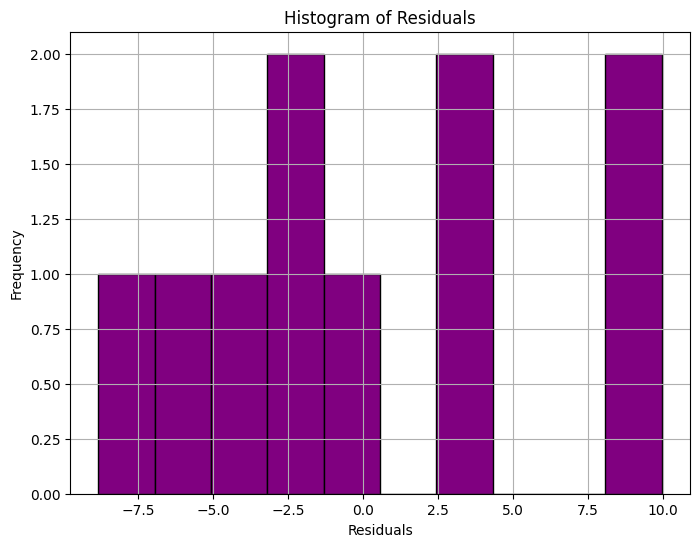

In [41]:
import tensorflow as tf
import numpy as np
import random
from IPython.display import display, Image, HTML
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import scipy.stats as stats
import os

# Load the saved model
try:
    model = tf.keras.models.load_model('best_model.keras')
    print("Model loaded successfully.")
except Exception as e:
    print(f"Error loading model: {e}")

# Define paths for the image dataset and MOS values
image_paths_file = 'test_images_new.txt'
mos_values_file = 'test_mos.txt'

# Load the image paths and MOS values
def load_image_paths(file_path):
    if not os.path.isfile(file_path):
        raise FileNotFoundError(f"Image paths file not found: {file_path}")
    with open(file_path, 'r') as f:
        paths = [line.strip() for line in f]
    print(f"Loaded {len(paths)} image paths.")
    return paths

def load_mos_values(file_path):
    if not os.path.isfile(file_path):
        raise FileNotFoundError(f"MOS values file not found: {file_path}")
    values = np.loadtxt(file_path, delimiter=',')
    print(f"Loaded MOS values for {len(values)} images.")
    return values

try:
    image_paths = load_image_paths(image_paths_file)
    mos_values = load_mos_values(mos_values_file)
except Exception as e:
    print(f"Error loading data: {e}")

# Define a function to preprocess images
def preprocess_image(path, size=(224, 224)):
    if not os.path.isfile(path):
        raise FileNotFoundError(f"Image file not found: {path}")
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, size)
    img = img / 255.0  # Normalize to [0, 1] range
    return img

# Define a function to get predictions and metrics
def predict_and_evaluate(image_paths, true_mos_values):
    predictions = []
    true_values = []
    rmses = []

    for i in range(len(image_paths)):
        image_path = image_paths[i]
        true_mos = true_mos_values[i]

        # Preprocess the image
        image = preprocess_image(image_path)
        image = np.expand_dims(image, axis=0)  # Add batch dimension

        # Predict the MOS value
        predicted_mos = model.predict(image)[0][0]

        # Calculate RMSE for this image
        rmse = np.sqrt(mean_squared_error([true_mos], [predicted_mos]))

        predictions.append(predicted_mos)
        true_values.append(true_mos)
        rmses.append(rmse)

    # Calculate overall metrics
    srcc, _ = stats.spearmanr(true_values, predictions)
    krcc, _ = stats.kendalltau(true_values, predictions)
    plcc = np.corrcoef(true_values, predictions)[0, 1]

    return predictions, true_values, srcc, krcc, plcc, rmses

# Select multiple random images
num_samples = 10  # Number of images to sample
indices = random.sample(range(len(image_paths)), num_samples)
sample_image_paths = [image_paths[i] for i in indices]
sample_mos_values = [mos_values[i] for i in indices]

print(f"Selected {num_samples} images for evaluation.")

# Predict and evaluate
predictions, true_values, srcc, krcc, plcc, rmses = predict_and_evaluate(sample_image_paths, sample_mos_values)

# Display results
for i in range(num_samples):
    img = Image(filename=sample_image_paths[i])
    display(img)
    print(f"Image: {sample_image_paths[i]}")
    print(f"True MOS: {sample_mos_values[i]}")
    print(f"Predicted MOS: {predictions[i]:.2f}")
    print(f"RMSE for this image: {rmses[i]:.2f}")

results = f"""
<h3>Evaluation Results</h3>
<p><b>Spearman Rank Correlation Coefficient (SRCC):</b> {srcc:.4f}</p>
<p><b>Kendall Rank Correlation Coefficient (KRCC):</b> {krcc:.4f}</p>
<p><b>Pearson Linear Correlation Coefficient (PLCC):</b> {plcc:.4f}</p>
"""
display(HTML(results))

# Visualization

# Scatter Plot of True vs Predicted MOS
plt.figure(figsize=(5,5))
plt.scatter(true_values, predictions, color='blue', label='Predicted vs True')
plt.plot([min(true_values), max(true_values)], [min(true_values), max(true_values)], color='red', linestyle='--', label='Perfect Prediction')
plt.xlabel('True MOS')
plt.ylabel('Predicted MOS')
plt.title('True MOS vs Predicted MOS')
plt.legend()
plt.grid(True)
plt.show()

# Residual Plot
residuals = np.array(predictions) - np.array(true_values)

plt.figure(figsize=(5,5))
plt.scatter(predictions, residuals, color='green')
plt.hlines(0, min(predictions), max(predictions), colors='red', linestyle='--')
plt.xlabel('Predicted MOS')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.grid(True)
plt.show()

# Histogram of Residuals
plt.figure(figsize=(8, 6))
plt.hist(residuals, bins=10, color='purple', edgecolor='black')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.grid(True)
plt.show()

